# Part I: Common Groundwork
## Dataset Preparation & Initial Analysis

In [ ]:
import os
from pathlib import Path
import random
import platform

import numpy as np
import pandas as pd
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Cluster or laptop
if platform.system() == "Windows":
    DATA_DIR = Path(r"yourpath")
else:
    DATA_DIR = Path.home() / "yourpath"

#PAths
IMG_DIR   = DATA_DIR / "images"
TRAIN_CSV = DATA_DIR / "train_2025.csv"
TEST_CSV  = DATA_DIR / "test_2025.csv"

print(DATA_DIR)
print(IMG_DIR)

# Constants

IMG_SIZE = 224

/home/tu/tu_tu/tu_zxoxe46/Practical Deep Learning/Assignment 2
/home/tu/tu_tu/tu_zxoxe46/Practical Deep Learning/Assignment 2/images


### 1. Data Loading:
Obtain the dataset consisting of over 16,000 images of
dresses and their corresponding labels from the provided files (train.csv and
test.csv). 

In [2]:
# Load data
train_df_full = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Shape and basic info
print("Train (Full) shape:", train_df_full.shape)
print("Test  shape:", test_df.shape)
train_df_full["garment_types"].value_counts(normalize=True)

Train (Full) shape: (13527, 13)
Test  shape: (3382, 13)


garment_types
casual_dress      0.351519
knitted_dress     0.146965
evening_dress     0.137946
jersey_dress      0.134028
maxi_dress        0.093517
occasion_dress    0.054779
shift_dress       0.029275
denim_dress       0.021439
shirt_dress       0.015820
work_dress        0.014711
Name: proportion, dtype: float64

### 2. Data Partitioning: 
Manually partition the train.csv data into training and
validation subsets (e.g., 80% train, 20% validation). Ensure reproducibility
(e.g., by setting a random seed). 

For training we can only use the train.csv file. This means also for validation of hyperparamters

In [3]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

# Validation-Train split
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df_full,test_size=0.20,random_state=SEED,stratify=train_df_full["garment_types"]) # Stratify for the minorities

print(f"Training samples : {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Check class distribution
print("Training class distribution:")
print(train_df["garment_types"].value_counts(normalize=True))
print("Validation class distribution:")
print(val_df["garment_types"].value_counts(normalize=True))

Training samples : 10821
Validation samples: 2706
Training class distribution:
garment_types
casual_dress      0.351539
knitted_dress     0.146937
evening_dress     0.137972
jersey_dress      0.133999
maxi_dress        0.093522
occasion_dress    0.054801
shift_dress       0.029295
denim_dress       0.021440
shirt_dress       0.015803
work_dress        0.014694
Name: proportion, dtype: float64
Validation class distribution:
garment_types
casual_dress      0.351441
knitted_dress     0.147081
evening_dress     0.137842
jersey_dress      0.134146
maxi_dress        0.093496
occasion_dress    0.054693
shift_dress       0.029194
denim_dress       0.021434
shirt_dress       0.015891
work_dress        0.014782
Name: proportion, dtype: float64


### 3. You will implement a custom torch.utils.data.Dataset class, 
let's call
it ImageDressDataset. This class is fundamental for loading your data
efficiently in PyTorch. 

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDressDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        Args:
            df: DataFrame with 'article_id' and 'garment_types' columns
            img_dir: Path to images directory
            transform: Optional transform to be applied on images
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform
        
        # Create label mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(df['garment_types'].unique()))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image filename and label
        img_name = self.df.iloc[idx]['article_id']
        label_str = self.df.iloc[idx]['garment_types']
        
        # Convert label to integer
        label = self.label_to_idx[label_str]
        
        # Construct full path and load image
        img_path = self.img_dir / f"{img_name}.jpg"
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Test the dataset
print("Unique garment types:", sorted(train_df['garment_types'].unique()))
print("Number of classes:", len(train_df['garment_types'].unique()))


Unique garment types: ['casual_dress', 'denim_dress', 'evening_dress', 'jersey_dress', 'knitted_dress', 'maxi_dress', 'occasion_dress', 'shift_dress', 'shirt_dress', 'work_dress']
Number of classes: 10


### 4. Data Visualization: 
Visualize a few samples from the dataset (at least 2
sample images from each dress category in your training set) along with their
labels to understand the data distribution. 

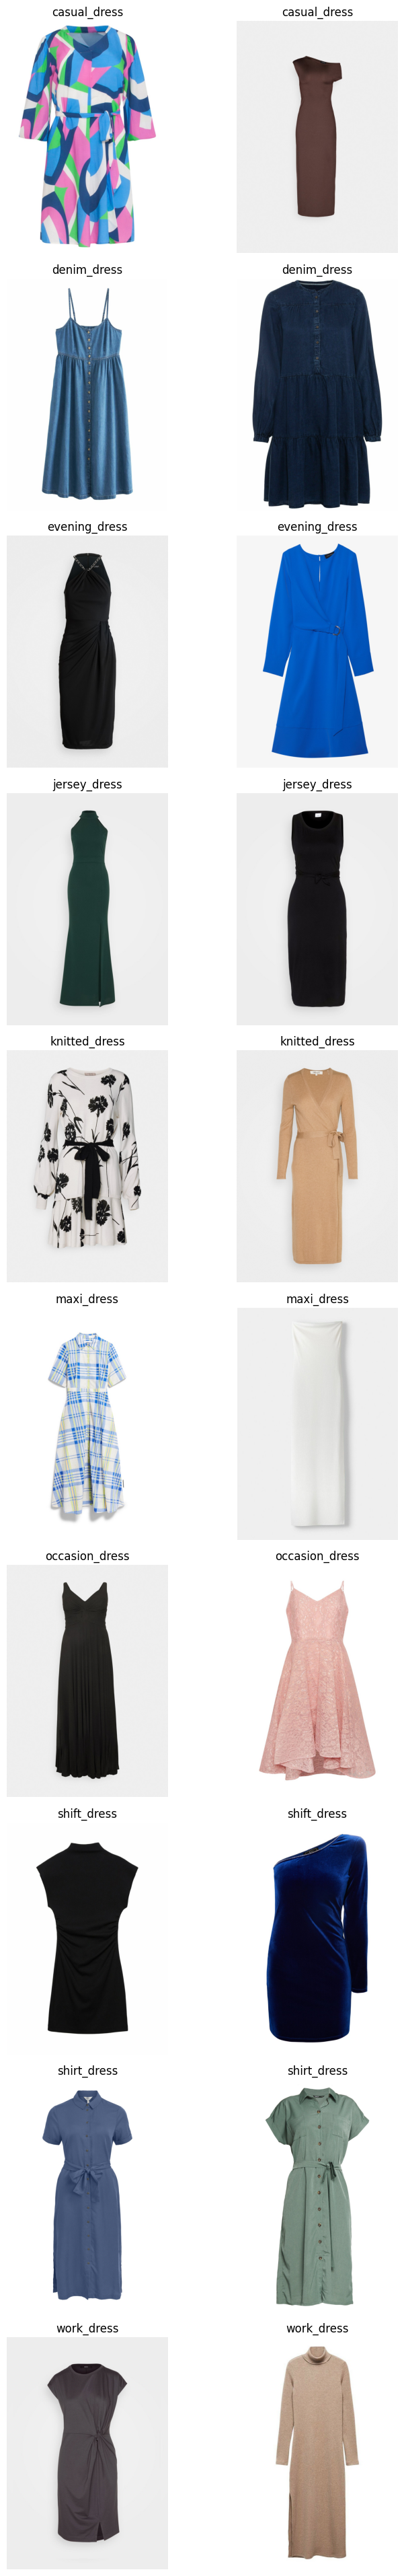

In [5]:
import matplotlib.pyplot as plt

# list of classes
classes = sorted(train_df['garment_types'].unique())

fig, axes = plt.subplots(len(classes), 2, figsize=(8, len(classes)*4))

for i, cls in enumerate(classes):
    # 2 random samples for each class
    samples = train_df[train_df['garment_types'] == cls].sample(2, random_state=SEED)
    for j, (_, row) in enumerate(samples.iterrows()):
        img_path = IMG_DIR / f"{row['article_id']}.jpg"
        img = Image.open(img_path).convert('RGB')
        axes[i, j].imshow(img)
        axes[i, j].set_title(cls, fontsize=12)
        axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Pre-processing of Images 
Implement this pre-processing sequence to your custom dataset:
- Resize image to make its longest side 224 pixels (maintaining aspect ratio).
- Apply the padding needed for the shorter side to make the image 224x224.

In [18]:
from torchvision import transforms
from torchvision.transforms import functional as F
import math
from PIL import Image

# Custom transform: resize keeping aspect ratio, then pad to 224×224
class ResizeAndPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        w, h = img.size  # get original dimensions
        # compute new dimensions
        if w > h:
            new_w = self.size
            new_h = math.floor(h / w * self.size)
        else:
            new_h = self.size
            new_w = math.floor(w / h * self.size)
        img = img.resize((new_w, new_h),
                         resample=Image.LANCZOS, # High-quality downsampling
                         reducing_gap=3.0 # Anti-aliasing
                         )

        # compute padding
        pad_w = self.size - new_w
        pad_h = self.size - new_h
        left = pad_w // 2; right = pad_w - left
        top  = pad_h // 2; bottom = pad_h - top

        return F.pad(img, (left, top, right, bottom))  # Pad

# Apply preprocessing
preprocess = transforms.Compose([
    ResizeAndPad(IMG_SIZE),
    transforms.ToTensor(), # before normalization
])

- Ensure your final output images from this step are exactly 224x224 pixels. 

In [20]:
# instantiate with preprocess only
train_dataset_pre = ImageDressDataset(train_df, IMG_DIR, transform=preprocess)

# grab one sample
img, _ = train_dataset_pre[1320]

print(img.shape)
print(type(img))
print(img.dtype)
print(img.min(), img.max())
print(img.mean(), img.std())

torch.Size([3, 224, 224])
<class 'torch.Tensor'>
torch.float32
tensor(0.) tensor(1.)
tensor(0.4941) tensor(0.4289)


Looking at some randomly drawn samples we see the size is correct and the pixel activations are roughly between 0 and 1, while the average activations lie around 0,5.

## Normalization: Standardizing Pixel Values 
Implement this normalization to the custom dataset in PyTorch using
torchvision.transforms.Normalize with the ImageNet mean and
standard deviation values.

In [21]:
# Normalization (Imagenet)
imagenet_norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std =[0.229, 0.224, 0.225],
)

# full transform = preprocess + normalization
full_transform = transforms.Compose([preprocess, imagenet_norm])

# Instantiate
train_dataset = ImageDressDataset(train_df, IMG_DIR, transform=full_transform)
val_dataset   = ImageDressDataset(val_df,   IMG_DIR, transform=full_transform)

- Ensure this transform is applied after the image
has been converted to a tensor and its pixel values scaled (e.g., to [0,1] by
transforms.ToTensor()).

In [24]:
print("Label mapping:")
for label, idx in train_dataset.label_to_idx.items():
    print(f"  {label}: {idx}")

train_dataset = ImageDressDataset(train_df, IMG_DIR, transform=full_transform)

img, _ = train_dataset[1320]
print(type(img))
print(img.shape)
print(img.dtype)
print(img.min(), img.max())
print(img.mean(), img.std())

Label mapping:
  casual_dress: 0
  denim_dress: 1
  evening_dress: 2
  jersey_dress: 3
  knitted_dress: 4
  maxi_dress: 5
  occasion_dress: 6
  shift_dress: 7
  shirt_dress: 8
  work_dress: 9
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.float32
tensor(-2.1179) tensor(2.6400)
tensor(0.2013) tensor(1.9039)


After normalizing, we have same shape but the range of activations become unrestricted. Since we normalize taking the imagenet values as reference, we see that the sd is broader in our sample. Our activatios vary/contrast roughly twice as more.